# Reading ICESat-2 Data in for Analysis
This notebook ({nb-download}`download <IS2_data_read-in.ipynb>`) illustrates the use of icepyx for reading ICESat-2 data files, loading them into a data object.
Currently the default data object is an Xarray Dataset, with ongoing work to provide support for other data object types.

For more information on how to order and download ICESat-2 data, see the [icepyx data access tutorial](https://icepyx.readthedocs.io/en/latest/example_notebooks/IS2_data_access.html).

### Motivation
Most often, when you open a data file, you must specify the underlying data structure and how you'd like the information to be read in.
A simple example of this, for instance when opening a csv or similarly delimited file, is letting the software know if the data contains a header row, what the data type is (string, double, float, boolean, etc.) for each column, what the delimeter is, and which columns or rows you'd like to be loaded.
Many ICESat-2 data readers are quite manual in nature, requiring that you accurately type out a list of string paths to the various data variables.

icepyx simplifies this process by relying on its awareness of ICESat-2 specific data file variable storage structure.
Instead of needing to manually iterate through the beam pairs, you can provide a few options to the `Read` object and icepyx will do the heavy lifting for you (as detailed in this notebook).

### Approach
If you're interested in what's happening under the hood: icepyx uses the [xarray](https://docs.xarray.dev/en/stable/) library to read in each of the requested variables of the dataset. icepyx formats each requested variable and then merges the read-in data from each of the variables to create a single data object. The use of xarray is powerful, because the returned data object can be used with relevant xarray processing tools.

Import packages, including icepyx

In [4]:
import icepyx as ipx

---------------------------------

## Quick-Start Guide
For those who might be looking into playing with this (but don't want all the details/explanations)

In [5]:
path_root = '/full/path/to/your/data/'
pattern = "processed_ATL{product:2}_{datetime:%Y%m%d%H%M%S}_{rgt:4}{cycle:2}{orbitsegment:2}_{version:3}_{revision:2}.h5"
reader = ipx.Read(path_root, "ATL06", pattern) # or ipx.Read(filepath, "ATLXX") if your filenames match the default pattern

You have 6 files matching the filename pattern to be read in.


In [6]:
reader.vars.append(beam_list=['gt1l', 'gt3r'], var_list=['h_li', "latitude", "longitude"])

In [7]:
ds = reader.load()
ds

/home/jovyan/envs/general/lib/python3.11/site-packages/icepyx/core/read.py:49: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  df.update({keyword: df[keyword].str[:-1].astype(np.datetime64)})
/home/jovyan/envs/general/lib/python3.11/site-packages/icepyx/core/read.py:49: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64

<xarray.Dataset>
Dimensions:              (photon_idx: 29027, spot: 2, gran_idx: 6)
Coordinates:
  * photon_idx           (photon_idx) int64 0 1 2 3 ... 29023 29024 29025 29026
  * spot                 (spot) uint8 2 5
  * gran_idx             (gran_idx) float64 8.49e+04 9.02e+04 ... 1.016e+05
    source_file          (gran_idx) <U72 '../../../../data/ATL06/processed_AT...
    delta_time           (gran_idx, photon_idx) datetime64[ns] 2019-02-22T01:...
Data variables:
    sc_orient            (gran_idx) int8 0 0 0 1 1 1
    cycle_number         (gran_idx) int8 2 2 2 5 5 5
    rgt                  (gran_idx) int16 849 902 910 986 1001 1016
    atlas_sdp_gps_epoch  (gran_idx) datetime64[ns] 2018-01-01T00:00:18 ... 20...
    data_start_utc       (gran_idx) datetime64[ns] 2019-02-22T01:03:44.199777...
    data_end_utc         (gran_idx) datetime64[ns] 2019-02-22T01:07:38.112326...
    h_li                 (spot, gran_idx, photon_idx) float32 nan nan ... nan
    latitude             (spot, gran_idx, photon_idx) float64 nan nan ... nan
    longitude            (spot, gran_idx, photon_idx) float64 nan nan ... nan
    gt                   (gran_idx, spot) <U4 'gt3r' 'gt1l' ... 'gt1l' 'gt3r'
Attributes:
    data_product:  ATL06
    Description:   The land_ice_height group contains the primary set of deri...
    data_rate:     Data within this group are sparse.  Data values are provid...

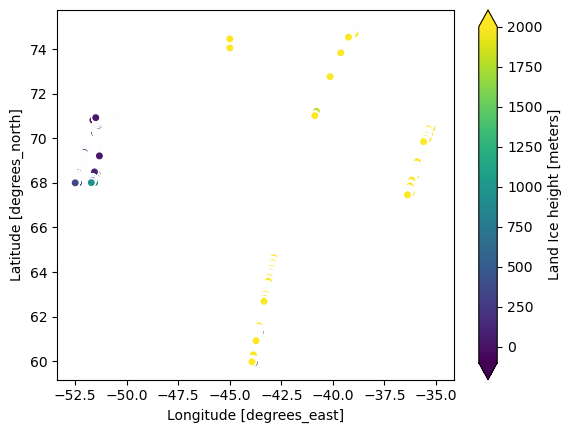

In [8]:
ds.plot.scatter(x="longitude", y="latitude", hue="h_li", vmin=-100, vmax=2000)

---------------------------------------
## Key steps for loading (reading) ICESat-2 data

Reading in ICESat-2 data with icepyx happens in a few simple steps:
1. Let icepyx know where to find your data (this might be local files or urls to data in cloud storage)
2. Tell icepyx how to interpret the filename format
3. Create an icepyx `Read` object
4. Make a list of the variables you want to read in (does not apply for gridded products)
5. Load your data into memory (or read it in lazily, if you're using Dask)

We go through each of these steps in more detail in this notebook.

### Step 0: Get some data if you haven't already
Here are a few lines of code to get you set up with a few data files if you don't already have some on your local system.

In [9]:
region_a = ipx.Query('ATL06',[-55, 68, -48, 71],['2019-02-22','2019-02-28'], \
                           start_time='00:00:00', end_time='23:59:59')

In [10]:
region_a.download_granules(path=path_root)

AttributeError: 'Query' object has no attribute '_session'

```{admonition} Important Authentication Update
Previously, icepyx required you to explicitly use the `.earthdata_login()` function to login. Running this function is no longer required, as icepyx will call the login function as needed. The user will still need to provide their credentials using one of the three methods decribed in the [ICESat-2 Data Access Notebook](https://icepyx.readthedocs.io/en/latest/example_notebooks/IS2_data_access.html) example. The `.earthdata_login()` function is still available for backwards compatibility.

If you are unable to remove `earthdata_login()` calls from your workflow, note that certain inputs, such as `earthdata_uid` and `email`, are no longer required. e.g. `region_a.earthdata_login(earthdata_uid, email)` becomes `region_a.earthdata_login()`
```

### Step 1: Set data source path

Provide a full path to the data to be read in (i.e. opened).
Currently accepted inputs are:
* a directory
* a single file

All files to be read in *must* have a consistent filename pattern.
If a directory is supplied as the data source, all files in any subdirectories that match the filename pattern will be included.

S3 bucket data access is currently under development, and requires you are registered with NSIDC as a beta tester for cloud-based ICESat-2 data.
icepyx is working to ensure a smooth transition to working with remote files.
We'd love your help exploring and testing these features as they become available!

In [11]:
path_root = '/full/path/to/your/data/'

In [13]:
# filepath = path_root + 'ATL06-20181214041627-Sample.h5'

In [14]:
# urlpath = 's3://nsidc-cumulus-prod-protected/ATLAS/ATL03/004/2019/11/30/ATL03_20191130221008_09930503_004_01.h5'

### Step 2: Create a filename pattern for your data files

Files provided by NSIDC typically match the format `"ATL{product:2}_{datetime:%Y%m%d%H%M%S}_{rgt:4}{cycle:2}{orbitsegment:2}_{version:3}_{revision:2}.h5"` where the parameters in curly brackets indicate a parameter name (left of the colon) and character length or format (right of the colon).
Some of this information is used during data opening to help correctly read and label the data within the data structure, particularly when multiple files are opened simultaneously.

By default, icepyx will assume your filenames follow the default format.
However, you can easily read in other ICESat-2 data files by supplying your own filename pattern.
For instance, `pattern="ATL{product:2}-{datetime:%Y%m%d%H%M%S}-Sample.h5"`. A few example patterns are provided below.

In [15]:
# pattern = 'ATL06-{datetime:%Y%m%d%H%M%S}-Sample.h5'
# pattern = 'ATL{product:2}-{datetime:%Y%m%d%H%M%S}-Sample.h5'

In [16]:
# pattern = "ATL{product:2}_{datetime:%Y%m%d%H%M%S}_{rgt:4}{cycle:2}{orbitsegment:2}_{version:3}_{revision:2}.h5"

In [17]:
# grid_pattern = "ATL{product:2}_GL_0311_{res:3}m_{version:3}_{revision:2}.nc"

In [18]:
pattern = "processed_ATL{product:2}_{datetime:%Y%m%d%H%M%S}_{rgt:4}{cycle:2}{orbitsegment:2}_{version:3}_{revision:2}.h5"

### Step 3: Create an icepyx read object

The `Read` object has two required inputs:
- `path` = a string with the full file path or full directory path to your hdf5 (.h5) format files.
- `product` = the data product you're working with, also known as the "short name".

The `Read` object also accepts the optional keyword input:
- `pattern` = a formatted string indicating the filename pattern required for Intake's path_as_pattern argument.

In [19]:
reader = ipx.Read(data_source=path_root, product="ATL06", filename_pattern=pattern) # or ipx.Read(filepath, "ATLXX") if your filenames match the default pattern

You have 6 files matching the filename pattern to be read in.


In [20]:
reader._filelist

['../../../../data/ATL06/processed_ATL06_20190226005526_09100205_006_02.h5',
 '../../../../data/ATL06/processed_ATL06_20191201105502_10010505_006_01.h5',
 '../../../../data/ATL06/processed_ATL06_20190225121032_09020203_006_02.h5',
 '../../../../data/ATL06/processed_ATL06_20190222010344_08490205_006_02.h5',
 '../../../../data/ATL06/processed_ATL06_20191130112041_09860505_006_01.h5',
 '../../../../data/ATL06/processed_ATL06_20191202102922_10160505_006_01.h5']

### Step 4: Specify variables to be read in

To load your data into memory or prepare it for analysis, icepyx needs to know which variables you'd like to read in.
If you've used icepyx to download data from NSIDC with variable subsetting (which is the default), then you may already be familiar with the icepyx `Variables` module and how to create and modify lists of variables.
We showcase a specific case here, but we encourage you to check out [the icepyx Variables example](https://icepyx.readthedocs.io/en/latest/example_notebooks/IS2_data_variables.html) for a thorough trip through how to create and manipulate lists of ICESat-2 variable paths (examples are provided for multiple data products).

If you want to see a \[likely very long\] list of all path + variable combinations available to you, this unmutable (unchangeable) list is generated by default from the first file in your list (so not all variables may be contained in all of the files, depending on how you are accessing the data).

In [21]:
reader.vars.avail()

['ancillary_data/atlas_sdp_gps_epoch',
 'ancillary_data/control',
 'ancillary_data/data_end_utc',
 'ancillary_data/data_start_utc',
 'ancillary_data/end_cycle',
 'ancillary_data/end_delta_time',
 'ancillary_data/end_geoseg',
 'ancillary_data/end_gpssow',
 'ancillary_data/end_gpsweek',
 'ancillary_data/end_orbit',
 'ancillary_data/end_region',
 'ancillary_data/end_rgt',
 'ancillary_data/granule_end_utc',
 'ancillary_data/granule_start_utc',
 'ancillary_data/land_ice/dt_hist',
 'ancillary_data/land_ice/fit_maxiter',
 'ancillary_data/land_ice/fpb_maxiter',
 'ancillary_data/land_ice/max_res_ids',
 'ancillary_data/land_ice/min_dist',
 'ancillary_data/land_ice/min_gain_th',
 'ancillary_data/land_ice/min_n_pe',
 'ancillary_data/land_ice/min_n_sel',
 'ancillary_data/land_ice/min_signal_conf',
 'ancillary_data/land_ice/n_hist',
 'ancillary_data/land_ice/n_sigmas',
 'ancillary_data/land_ice/nhist_bins',
 'ancillary_data/land_ice/proc_interval',
 'ancillary_data/land_ice/qs_lim_bsc',
 'ancillary_

To make things easier, you can use icepyx's built-in default list that loads commonly used variables for your non-gridded data product, or create your own list of variables to be read in.
icepyx will determine what variables are available for you to read in by creating a list from one of your source files.
If you have multiple files that you're reading in, icepyx will automatically generate a list of filenames and take the first one to get the list of available variables.

Thus, if you have different variables available across files (even from the same data product), you may run into issues and need to come up with a workaround (we can help you do so!).
We anticipate most users will have the minimum set of variables they are seeking to load available across all data files, so we're not currently developing this feature.
Please get in touch if it would be a helpful feature for you or if you encounter this problem!

You may create a variable list for gridded ICESat-2 products. However, all variables in the file will still be added to your DataSet. (This is an area we're currently exploring on expanding - please let us know if you're working on this and would like to contribute!)

For a basic case, let's say we want to read in height, latitude, and longitude for all beam pairs.
We create our variables list as

In [28]:
reader.vars.append(var_list=['h_li', "latitude", "longitude"])

Then we can view a dictionary of the variables we'd like to read in.

In [29]:
reader.vars.wanted

{'sc_orient': ['orbit_info/sc_orient'],
 'atlas_sdp_gps_epoch': ['ancillary_data/atlas_sdp_gps_epoch'],
 'cycle_number': ['orbit_info/cycle_number'],
 'rgt': ['orbit_info/rgt'],
 'data_start_utc': ['ancillary_data/data_start_utc'],
 'data_end_utc': ['ancillary_data/data_end_utc'],
 'h_li': ['gt1l/land_ice_segments/h_li',
  'gt1r/land_ice_segments/h_li',
  'gt2l/land_ice_segments/h_li',
  'gt2r/land_ice_segments/h_li',
  'gt3l/land_ice_segments/h_li',
  'gt3r/land_ice_segments/h_li'],
 'latitude': ['gt1l/land_ice_segments/latitude',
  'gt1r/land_ice_segments/latitude',
  'gt2l/land_ice_segments/latitude',
  'gt2r/land_ice_segments/latitude',
  'gt3l/land_ice_segments/latitude',
  'gt3r/land_ice_segments/latitude'],
 'longitude': ['gt1l/land_ice_segments/longitude',
  'gt1r/land_ice_segments/longitude',
  'gt2l/land_ice_segments/longitude',
  'gt2r/land_ice_segments/longitude',
  'gt3l/land_ice_segments/longitude',
  'gt3r/land_ice_segments/longitude']}

Don't forget - if you need to start over, and re-generate your wanted variables list, it's easy!

In [24]:
reader.vars.remove(all=True)

### Step 5: Loading your data

Now that you've set up all the options, you're ready to read your ICESat-2 data into memory!

In [30]:
ds = reader.load()

/home/jovyan/envs/general/lib/python3.11/site-packages/icepyx/core/read.py:49: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  df.update({keyword: df[keyword].str[:-1].astype(np.datetime64)})
/home/jovyan/envs/general/lib/python3.11/site-packages/icepyx/core/read.py:49: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64

Within a Jupyter Notebook, you can get a summary view of your data object.

***ATTENTION: icepyx loads your data by creating an Xarray DataSet for each input granule and then merging them. In some cases, the automatic merge fails and needs to be handled manually. In these cases, icepyx will return a warning with the error message from the failed Xarray merge and a list of per-granule DataSets***

This can happen if you unintentionally provide the same granule multiple times with different filenames or in segmented products where the rgt+cycle automatically generated `gran_idx` values match. In this latter case, you can simply provide unique `gran_idx` values for each DataSet in `ds` and run `import xarray as xr` and `ds_merged = xr.merge(ds)` to create one merged DataSet.

In [26]:
ds

<xarray.Dataset>
Dimensions:              (photon_idx: 29027, spot: 2, gran_idx: 6)
Coordinates:
  * photon_idx           (photon_idx) int64 0 1 2 3 ... 29023 29024 29025 29026
  * spot                 (spot) uint8 2 5
  * gran_idx             (gran_idx) float64 8.49e+04 9.02e+04 ... 1.016e+05
    source_file          (gran_idx) <U72 '../../../../data/ATL06/processed_AT...
    delta_time           (gran_idx, photon_idx) datetime64[ns] 2019-02-22T01:...
Data variables:
    sc_orient            (gran_idx) int8 0 0 0 1 1 1
    cycle_number         (gran_idx) int8 2 2 2 5 5 5
    rgt                  (gran_idx) int16 849 902 910 986 1001 1016
    atlas_sdp_gps_epoch  (gran_idx) datetime64[ns] 2018-01-01T00:00:18 ... 20...
    data_start_utc       (gran_idx) datetime64[ns] 2019-02-22T01:03:44.199777...
    data_end_utc         (gran_idx) datetime64[ns] 2019-02-22T01:07:38.112326...
    h_li                 (spot, gran_idx, photon_idx) float32 nan nan ... nan
    latitude             (spot, gran_idx, photon_idx) float64 nan nan ... nan
    longitude            (spot, gran_idx, photon_idx) float64 nan nan ... nan
    gt                   (gran_idx, spot) <U4 'gt3r' 'gt1l' ... 'gt1l' 'gt3r'
Attributes:
    data_product:  ATL06
    Description:   The land_ice_height group contains the primary set of deri...
    data_rate:     Data within this group are sparse.  Data values are provid...

## On to data analysis!

From here, you can begin your analysis.
Ultimately, icepyx aims to include an Xarray extension with ICESat-2 aware functions that allow you to do things like easily use only data from strong beams.
That functionality is still in development.
For fun, we've included a basic plot made with Xarray's built in functionality.

In [27]:
ds.plot.scatter(x="longitude", y="latitude", hue="h_li", vmin=-100, vmax=2000)

A developer note to users:
our next steps will be to create an xarray extension with ICESat-2 aware functions (like "get_strong_beams", etc.).
Please let us know if you have any ideas or already have functions developed (we can work with you to add them, or add them for you!).

#### Credits
* original notebook by: Jessica Scheick
* notebook contributors: Wei Ji and Tian